## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
def preproc_x(x):
    x = x.astype("float32")
    x = x.reshape(x.shape[0],-1)
    x = scaler.fit_transform(x)
    return x

def preproc_y(y):
    y = keras.utils.to_categorical(y, num_classes=10)
    return y  

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
"""
建立你的神經網路
"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

def build_mlp(input_dim, layer_output_units, output_units, regularizer=None, dropout_ratio=None, isBN=True):
    model = Sequential()
    for i, untis in enumerate(layer_output_units):  
        if i == 0:
            model.add(Dense(units=untis, 
                            input_dim=input_dim,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
            if isBN:
                model.add(BatchNormalization())
        else:
            model.add(Dense(units=untis,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
            if isBN:
                model.add(BatchNormalization())

    if dropout_ratio:
        model.add(Dropout(dropout_ratio))
        
    model.add(Dense(units=output_units,
                kernel_initializer='normal', 
                activation='softmax'))
    return model  

In [6]:
"""
訓練模型
"""
def complie_train_model(model, optimizer,epochs, batch_size, x_train, y_train, x_test, y_test):
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
          epochs= epochs, 
          batch_size=batch_size, 
          validation_data=(x_test, y_test), 
          shuffle=True)
    return model

In [7]:
"""
以視覺畫方式檢視訓練過程
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_train_history(results):
    for i, result in enumerate(results):
        history = result["model"].history.history
        tag = "({})".format(result["tag"])
        df_acc = pd.DataFrame({"acc"+tag:history["acc"], "val_acc"+tag:history["val_acc"]})
        df_loss = pd.DataFrame({"loss"+tag:history["loss"], "val_loss"+tag:history["val_loss"]})
        if i ==0:
            df_acc_results = df_acc.copy()
            df_loss_results = df_loss.copy()
        else:
            df_acc_results= pd.concat([df_acc_results, df_acc], axis=1)
            df_loss_results= pd.concat([df_loss_results, df_loss], axis=1)    

    fig, ax = plt.subplots(1,2, figsize=(18,5))
    styles = ['bs-','ro-','y^-', 'g--']    
    g1 = df_acc_results.plot.line(style=styles, ax =ax[0])
    g1.set_xlabel("Epoch")
    g1.set_ylabel("Acc") 
    
    g2 = df_loss_results.plot.line(style=styles, ax =ax[1])
    g2.set_xlabel("Epoch")
    g2.set_ylabel("Loss") 
    return df_acc_results, df_loss_results

# Batch Normalziation is placed after Dense layer

In [11]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = [256]
MOMENTUM = 0.95
DROPOUT_EXP = 0.25
L2_EXP = 1e-2

In [12]:
"""
撰寫你的訓練流程並紀錄結果 
"""

results = list()

for bsize in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Batch_Size={}".format(bsize))
    regularizer = keras.regularizers.l1_l2(l1=L2_EXP, l2=L2_EXP)
    model = build_mlp(input_dim=x_train.shape[1], layer_output_units=[256,128], output_units=10, regularizer=None, isBN=True)
    
    optimizer =  keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model = complie_train_model(model, optimizer,EPOCHS, bsize, x_train, y_train, x_test, y_test)
    
    results.append({"tag":bsize, "model":model})

Batch_Size=256
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 20s 391us/step - loss: 1.9432 - acc: 0.3033 - val_loss: 1.7493 - val_acc: 0.3824
Epoch 2/10
50000/50000 [==============================] - 14s 284us/step - loss: 1.6858 - acc: 0.4038 - val_loss: 1.6363 - val_acc: 0.4232
Epoch 3/10
50000/50000 [==============================] - 14s 287us/step - loss: 1.5927 - acc: 0.4360 - val_loss: 1.5732 - val_acc: 0.4412
Epoch 4/10
50000/50000 [==============================] - 14s 287us/step - loss: 1.5293 - acc: 0.4569 - val_loss: 1.5335 - val_acc: 0.4548
Epoch 5/10
50000/50000 [==============================] - 15s 293us/step - loss: 1.4776 - acc: 0.4768 - val_loss: 1.5007 - val_acc: 0.4646
Epoch 6/10
50000/50000 [==============================] - 15s 291us/step - loss: 1.4344 - acc: 0.4907 - val_loss: 1.4753

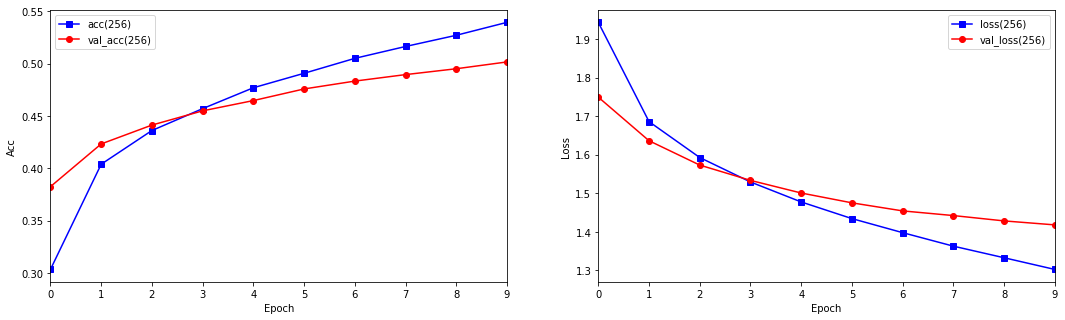

In [13]:
"""
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

df_acc_results, df_loss_results = show_train_history(results)

# Move Batch Normalization before Dense layer

In [14]:
"""
建立你的神經網路
"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

def build_mlp(input_dim, layer_output_units, output_units, regularizer=None, dropout_ratio=None, isBN=True):
    model = Sequential()
    for i, untis in enumerate(layer_output_units):  
        if i == 0:
            if isBN:
                model.add(BatchNormalization())            
            model.add(Dense(units=untis, 
                            input_dim=input_dim,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
        else:
            if isBN:
                model.add(BatchNormalization())            
            model.add(Dense(units=untis,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))


    if dropout_ratio:
        model.add(Dropout(dropout_ratio))
        
    model.add(Dense(units=output_units,
                kernel_initializer='normal', 
                activation='softmax'))
    return model 

In [15]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = [256]
MOMENTUM = 0.95
DROPOUT_EXP = 0.25
L2_EXP = 1e-2

In [16]:
"""
撰寫你的訓練流程並紀錄結果 
"""

results = list()

for bsize in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Batch_Size={}".format(bsize))
    regularizer = keras.regularizers.l1_l2(l1=L2_EXP, l2=L2_EXP)
    model = build_mlp(input_dim=x_train.shape[1], layer_output_units=[256,128], output_units=10, regularizer=None, isBN=True)
    
    optimizer =  keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model = complie_train_model(model, optimizer,EPOCHS, bsize, x_train, y_train, x_test, y_test)
    
    results.append({"tag":bsize, "model":model})

Batch_Size=256
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 24s 488us/step - loss: 2.0774 - acc: 0.2634 - val_loss: 1.8778 - val_acc: 0.3479
Epoch 2/10
50000/50000 [==============================] - 21s 429us/step - loss: 1.8033 - acc: 0.3673 - val_loss: 1.7399 - val_acc: 0.3869
Epoch 3/10
50000/50000 [==============================] - 22s 446us/step - loss: 1.6993 - acc: 0.4004 - val_loss: 1.6628 - val_acc: 0.4143
Epoch 4/10
50000/50000 [==============================] - 21s 418us/step - loss: 1.6314 - acc: 0.4250 - val_loss: 1.6092 - val_acc: 0.4289
Epoch 5/10
50000/50000 [==============================] - 21s 425us/step - loss: 1.5815 - acc: 0.4421 - val_loss: 1.5719 - val_acc: 0.4479
Epoch 6/10
50000/50000 [==============================] - 21s 428us/step - loss: 1.5397 - acc: 0.4568 - val_loss: 1.5403 - val_acc: 0.4587
Epoch 7/10
50000/50000 [==============================] - 22s 434us/step - loss: 1.5042 - acc: 0.4681

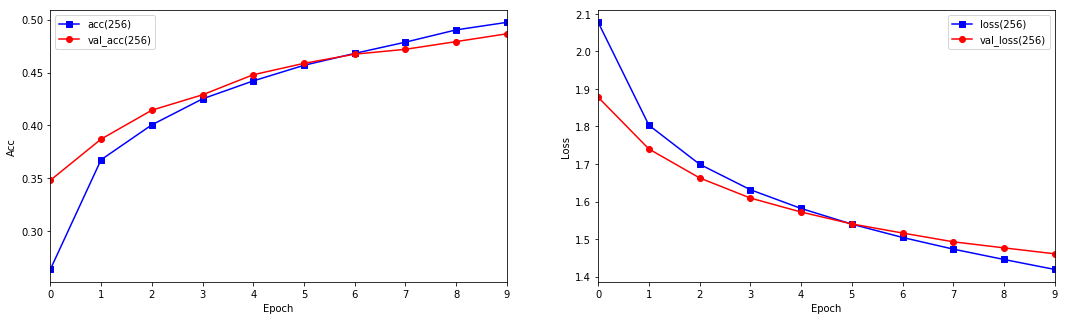

In [17]:
"""
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

df_acc_results, df_loss_results = show_train_history(results)